In [121]:
"""Created by Ehsan Ghane Feb 2024"""

# modified: March 19 2024

'Created by Ehsan Ghane Feb 2024'

In [122]:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)
print ("Today's date:  = %s/%s/%s" % (e.day, e.month, e.year))
print ("The time is now: = %s:%s:%s" % (e.hour, e.minute, e.second))

Current date and time = 2024-10-22 17:04:24.052370
Today's date:  = 22/10/2024
The time is now: = 17:4:24


## 1- Import packages

In [123]:
import sys
sys.version
from pathlib import Path
print(Path.cwd())


import numpy as np
import pandas as pd
import scipy.io as sio
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

import matplotlib.pyplot as plt
import random
import matplotlib as mpl
mpl.rcParams['font.size'] = 14


from torch.cuda import current_device, get_device_name

if torch.cuda.is_available():
    print(f'Current GPU: {get_device_name(current_device())}')
else:
    print('GPU not available.')

d:\1_PhD_projects\3_code\Data_generation_for_the_mean_field_solution\PyFormatPhase2\Phase_2\last_version_
Current GPU: NVIDIA GeForce RTX 4090


## 2- Data prepration

In [124]:
# The clean_dataset function to delete samples...
#with a length less than 101 and truncate samples with a length greater than 101 to only include the first 101 time steps. Here's the modified function:

# ref: https://se.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html
def clean_rand_fft_dataset(X, y):
    #function to keep only samples with length=>101 
    error_idx = []
    l = y.shape[0]
    for i in range(l):
        if y[i][0].shape[1] < 101:
            error_idx.append(i)
    
    cleaned_X = np.delete(X, error_idx, axis=0)
    cleaned_y = np.delete(y, error_idx, axis=0)

    cleaned_X_tr = []
    cleaned_y_tr = []

    for i in range(cleaned_X.shape[0]):
        # Truncate or pad sequences to 101 time steps
        truncated_X = cleaned_X[i][0][:, :101]
        truncated_y = cleaned_y[i][0][:, :101]
        cleaned_X_tr.append(truncated_X.transpose())
        cleaned_y_tr.append(truncated_y.transpose())

    print(len(cleaned_X_tr))
    return np.array(cleaned_X_tr), np.array(cleaned_y_tr)
"""
# as an ulternative, think of resizing the larger or shorter sequences
# The clean_dataset function to delete samples with ...
#a length less than 101 and truncate samples with a length greater than 101 to only include the first 101 time steps. Here's the modified function:
"""
# ref: https://se.mathworks.com/help/deeplearning/ug/long-short-term-memory-networks.html
def clean_shear_fft_dataset(X, y):
    error_idx = []
    l = y.shape[0]
    min_length= 8
    for i in range(l):
        if y[i][0].shape[1] < min_length:
            error_idx.append(i)
    
    cleaned_X = np.delete(X, error_idx, axis=0)
    cleaned_y = np.delete(y, error_idx, axis=0)

    cleaned_X_tr = []
    cleaned_y_tr = []

    for i in range(cleaned_X.shape[0]):
        # Truncate or pad sequences to 101 time steps
        truncated_X = cleaned_X[i][0][:, :min_length]
        truncated_y = cleaned_y[i][0][:, :min_length]
        cleaned_X_tr.append(truncated_X.transpose())
        cleaned_y_tr.append(truncated_y.transpose())

    print(len(cleaned_X_tr))
    return np.array(cleaned_X_tr), np.array(cleaned_y_tr), error_idx


In [125]:
def interpolate_time_series(data, new_length=200):
    """
    Interpolates each feature in the data from the current length to a new length.
    """
    batch_size, current_length, num_features = data.shape
    new_time_scale = np.linspace(0, 1, new_length)
    old_time_scale = np.linspace(0, 1, current_length)
    interpolated_data = np.zeros((batch_size, new_length, num_features))
    
    for i in range(batch_size):
        for j in range(num_features):
            interpolated_data[i, :, j] = np.interp(new_time_scale, old_time_scale, data[i, :, j])
    
    return interpolated_data


In [126]:
from sklearn.preprocessing import RobustScaler

# function to scale data into between -1 and 1

# The input to fit_transform() must be in 2D, so we reshape the 1D data[i, :] into the 2D [num_samples * sequence_length, features]
# fit() + transform() + reshape() + flatten ()
# scalers are important for later use, such as scaling test data using the same parameters used for scaling the training data.

def normalizer(data, scalers=None):
    # Reshape data to (num_samples * sequence_length, num_features)
    num_samples, sequence_length, num_features = data.shape
    data_reshaped = data.reshape(-1, num_features)
    
    if scalers is None:
        scalers = []
    
    data_scaled = np.zeros_like(data_reshaped)
    
    for i in range(num_features):
        if scalers is None or len(scalers) <= i or scalers[i] is None:
            # If no scalers provided or scaler not available, create a new one
            scaler = RobustScaler()
            scaler.fit(data_reshaped[:, i].reshape(-1, 1))
            scalers.append(scaler)
        else:
            # Use provided scaler
            scaler = scalers[i]
        
        data_scaled[:, i] = scaler.transform(data_reshaped[:, i].reshape(-1, 1)).flatten()
    
    data_scaled_reshaped = data_scaled.reshape(num_samples, sequence_length, num_features)
    
    return data_scaled_reshaped, scalers


# function to generater data_loader for training, validation and test set in both mean and full field samples
### Numpy into pytorch tensors
def turn_to_loader(xtrain,ytrain,
                   xval,yval,
                   xtest,ytest, batch_size = None):
    
    if batch_size is None:
        batch_size=32
    
    xtrain_scaled=xtrain
    xval_scaled=xval
    xtest_scaled=xtest
    ytrain_scaled=ytrain
    yval_scaled=yval
    ytest_scaled=ytest
    
    # Apply Min-Max scaling
   
    xtrain_scaled, x_scaler = normalizer(xtrain)
    ytrain_scaled, y_scaler = normalizer(ytrain)
    xval_scaled, _ = normalizer(xval, scalers=x_scaler)
    xtest_scaled, _ = normalizer(xtest, scalers=x_scaler)
    yval_scaled, _ = normalizer(yval, scalers=y_scaler)
    ytest_scaled, _ = normalizer(ytest, scalers=y_scaler)
 

    # Create TensorDatasets
    train_dataset = TensorDataset(
        torch.from_numpy(xtrain_scaled).float(),
        torch.from_numpy(ytrain_scaled).float())
        #ytrain_tensor
    val_dataset = TensorDataset(
        torch.from_numpy(xval_scaled).float(),
        torch.from_numpy(yval_scaled).float())
        #yval_tensor

    test_dataset = TensorDataset(
        torch.from_numpy(xtest_scaled).float(),
        torch.from_numpy(ytest_scaled).float())

    # Create DataLoader

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader , x_scaler, y_scaler



In [127]:

def ploting_loss_function(train_losses, val_losses, train_losses_iter):
        
    # Create figure and primary axes
    fig, ax1 = plt.subplots()

    # Plotting the training and validation loss over epochs on primary axes
    ax1.plot(train_losses, label='Training Loss (Epoch)', linestyle='--', color='black', marker='*')
    ax1.plot(val_losses, label='Validation Loss (Epoch)', linestyle='--', color='darkred', marker='^')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss (log scale)')

    # Create secondary x-axis for iterations
    ax2 = ax1.twiny()

    # Plotting the training and validation loss over iterations on secondary axes
    #ax2.plot(val_losses_iter, label='Validation Loss (Iteration)', linestyle=':', color='red', marker='x')
    ax2.plot(train_losses_iter, label='Training Loss (Iteration)', linestyle='--', color='black', alpha=0.3)
    ax2.set_xlabel('Batch iteration')

    # Ensure the secondary x-axis ticks are synchronized with primary x-axis
    ax2.set_xticks([])  # Hide secondary x-axis ticks

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Get the last values of x and y for legend placement
    last_epoch = len(train_losses)
    last_train_loss = train_losses[-1]
    last_val_loss = val_losses[-1]

    # Remove legend border and increase font size
    legend = ax1.legend(loc=(0.5, 0.77))
    legend2 = ax2.legend(loc=(0.5, 0.9))
    frame = legend.get_frame()
    frame2 = legend2.get_frame()
    frame.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend.get_texts())  # Set font size
    frame2.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend2.get_texts())  # Set font size

    # Adding text to display the last values
    ax1.text(last_epoch, last_train_loss, f'Last Train Loss: {last_train_loss:.4f}', ha='right', va='top')
    ax1.text(last_epoch, last_val_loss, f'Last Val Loss: {last_val_loss:.4f}', ha='right', va='top')

    # Manually set the tick positions and labels for the secondary x-axis
    iteration_labels = [str(i) for i in range(0, len(train_losses_iter), 2000)]  # Labels for every 1000th iteration
    iteration_ticks = [i for i in range(0, len(train_losses_iter), 2000)]  # Tick positions for every 1000th iteration
    ax2.set_xticks(iteration_ticks)
    ax2.set_xticklabels(iteration_labels)

    plt.show()
    return fig

#import numpy as np
#import matplotlib.pyplot as plt

def plot_input_sample(test_loader, sample_id=None):
    if sample_id is None:
        sample_id = np.random.randint(1, 8)
    print(f'Plotting input load from sample {sample_id}')

    x_target, y_target = test_loader.dataset[sample_id]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Plot x_target in the first subplot
    ax1.plot(x_target[:, 0], label=r'$\varepsilon_1$')
    ax1.plot(x_target[:, 1], label=r'$\varepsilon_2$')
    ax1.plot(x_target[:, 2], label=r'$\varepsilon_3$')
    ax1.plot(x_target[:, 3], label=r'$\varepsilon_4$')
    ax1.plot(x_target[:, 4], label=r'$\varepsilon_5$')
    ax1.plot(x_target[:, 5], label=r'$\varepsilon_6$')
    ax1.plot(x_target[:, 6], label=r'$\varepsilon_{eq}$')
    ax1.plot(x_target[:, 7], label=r'$\varepsilon^1_p$')
    ax1.plot(x_target[:, 8], label=r'$\varepsilon^2_p$')
    ax1.plot(x_target[:, 9], label=r'$\varepsilon^3_p$')
    ax1.set_xlabel('Time increment')
    ax1.set_ylabel(r'Normalized Strain, $\varepsilon$')
    ax1.legend()

    # Plot y_target in the second subplot
    ax2.plot(y_target[:, 0], label=r'$\sigma_1$')
    ax2.plot(y_target[:, 1], label=r'$\sigma_2$')
    ax2.plot(y_target[:, 2], label=r'$\sigma_3$')
    ax2.plot(y_target[:, 3], label=r'$\sigma_4$')
    ax2.plot(y_target[:, 4], label=r'$\sigma_5$')
    ax2.plot(y_target[:, 5], label=r'$\sigma_6$')
    ax2.plot(y_target[:, 6], label=r'$\sigma_{eq}$')
    ax2.plot(y_target[:, 7], label=r'$\sigma^1_p$')
    ax2.plot(y_target[:, 8], label=r'$\sigma^2_p$')
    ax2.plot(y_target[:, 9], label=r'$\sigma^3_p$')
    ax2.set_xlabel('Time increment')
    ax2.set_ylabel(r'Normalized Stress, $\sigma$') #the values are scaled using RubustScaler and are not in [MPa]
    ax2.legend()

    plt.tight_layout()
    plt.show()
    #save.fig()

# A function to evaluate the loss against samples in the test set and plot a random sample
def plot_test_sample(model, test_loader, test_sample_id=None, stress_components = None):

    # Testing phase
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"The model parameters are on {device}")
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_batch_x, test_batch_y = batch_x.to(device), batch_y.to(device)
            criterion = nn.MSELoss()
            test_outputs = model(test_batch_x)
            test_loss += criterion(test_outputs, test_batch_y).item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    #########################################
    # plotting a random sample from the test set
    if test_sample_id == None:
        test_sample_id = random.randint(0, len(test_loader.dataset)-1)
    
    print(f'Selected Test Sample ID: {test_sample_id}')

    x_target, y_target = test_loader.dataset[test_sample_id]

    # Load the pre-trained model
    model.eval()  # Set the model to evaluation mode

    # Make predictions
    with torch.no_grad():
        y_pred = model(x_target.to(device))

    # Convert predictions and y_target to NumPy arrays for plotting
    # Move tensors to the same device
    device_to_cpu = x_target.device
    print(f"The device is changed to {device_to_cpu} for plotting purposes")
    y_pred = y_pred.to(device_to_cpu)

    # Plot each line with a label

    if stress_components == None:
        stress_components = random.randint(0,10)
    
    print(f'Stress Component is: {stress_components}')

    plt.plot(y_pred[:, stress_components], label='Model prediction')
    plt.plot(y_target[:, stress_components], label='Target stress')
    # Remove legend border and increase font size
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_edgecolor('1.0')  # Set border color to white or any color you prefer
    plt.setp(legend.get_texts())  # Set font size

    # Set labels and title
    plt.xlabel('Time increment')
    # Create a list of LaTeX labels for stress components
    stress_labels = [r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', r'$\sigma_4$', r'$\sigma_5$', r'$\sigma_6$', r'$\sigma_{eq}$', r'$\sigma^1_p$', r'$\sigma^2_p$', r'$\sigma^3_p$']

    plt.ylabel(f'Normalized stress, {stress_labels[stress_components]}')

    # Show the plot
    plt.show()
    # plot ground truth data
    #plot_input_sample(test_loader, sample_id=test_sample_id)


def plot_sequence_length(input_data, database_name):
    length = []

    for i in range(input_data.shape[0]):
        length.append(input_data[i][0].shape[1])

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(len(length)), length)
    plt.xlabel('Length of data samples',fontsize=14)
    plt.ylabel('Number of samples',fontsize=14)
    #plt.title(f'Data Samples vs Length for "{database_name}"')

    # Add maximum and minimum borders
    max_length = max(length)
    min_length = min(length)
    plt.axvline(x=max_length, color='darkred', linestyle='--', label=f'Max Length: {max_length}')
    plt.axvline(x=min_length, color='darkred', linestyle='--', label=f'Min Length: {min_length}')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig()
    # Example usage:
    #plot_data(full_field_data['X_train_rand_FFT'], 'Random FFT Database')



## 3-Setup the running system

In [128]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.3 GB


## 4-Neural network model implementaiton

To train the PyTorch model using CUDA as the device, you need to ensure that both the model and the data are transferred to the GPU

In [129]:
#original GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=None):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=3)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        out, h_n = self.gru1(x)
        out = self.dropout(out)

        # out shape: (batch_size, sequence_length, hidden_size)
        out = self.fc(out)

        return out

In [130]:
# model trainer NO invariant considered
import os

class ModelTrainerDataDriven:
    def __init__(self, train_loader, val_loader, test_loader, hyperparameters):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.hyperparameters = hyperparameters
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.train_losses = []
        self.val_losses = []
        self.train_losses_iter = []
        self.val_losses_iter = []
        self.best_val_loss = float('inf')
        self.counter = 0

    def initialize_model(self):
        input_size = self.hyperparameters['input_size']
        hidden_size = self.hyperparameters['hidden_size']
        output_size = self.hyperparameters['output_size']
        drop_out = self.hyperparameters['drop_out']

        if 'pretrained_model_path' in self.hyperparameters:
            print("Model loaded from pretrained RNN") #, pretrained_model_path)
            pretrained_model_path = self.hyperparameters['pretrained_model_path']
            pretrained_model = GRUModel(input_size, hidden_size, output_size, drop_out)
            pretrained_model.load_state_dict(torch.load(pretrained_model_path))
            self.model = pretrained_model.to(self.device)
        else:
            print("Model is trained from scratch with random initialization")
            torch.manual_seed(self.hyperparameters['seed'])
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            self.model = GRUModel(input_size, hidden_size, output_size, drop_out).to(self.device)
            
        for param in self.model.parameters():
            #param.requires_grad = False
            print('initial parameter space shape: ',param.shape)
            #print(param)
            break

    def define_loss_optimizer_scheduler(self):
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hyperparameters['learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.9)

    def train(self):
        num_epochs = self.hyperparameters['num_epochs']
        patience = self.hyperparameters['patience']

        start = time.time()
        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for batch_x, batch_y in self.train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                                    # Both losses are combiled here
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                self.train_losses_iter.append(loss.item())

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch_x, val_batch_y in self.val_loader:
                    val_batch_x, val_batch_y = val_batch_x.to(self.device), val_batch_y.to(self.device)
                    val_outputs = self.model(val_batch_x)
                    val_loss += self.criterion(val_outputs, val_batch_y)

            val_loss /= len(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_losses_iter.append(val_loss)

            self.scheduler.step()

            print(f'\nEpoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1} due to no improvement in validation loss.')
                break

        model_directory = self.hyperparameters['save_directory']
        torch.save(self.model.state_dict(), self.hyperparameters['save_directory']+self.hyperparameters['model_name'])
        print("`\n model saved as: ", model_directory)
        end = time.time()
        print("\nThe time spend on the training is :", (end-start) * 10**3, "ms")

    def plot_loss_function(self):
        self.val_losses = [loss.cpu() for loss in self.val_losses]
        fig = ploting_loss_function(self.train_losses, self.val_losses, self.train_losses_iter)
        filename = f'GRU_MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png'
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.png')
        #fig.savefig(f'MSE_loss_lr_{self.hyperparameters["learning_rate"]}_patience_{self.hyperparameters["patience"]}.eps')
        #fig.savefig(os.path.join(self.hyperparameters['save_directory'], filename))

    def evaluate_test_set(self):
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for test_batch_x, test_batch_y in self.test_loader:
                test_batch_x, test_batch_y = test_batch_x.to(self.device), test_batch_y.to(self.device)
                test_outputs = self.model(test_batch_x)
                test_loss += self.criterion(test_outputs, test_batch_y).item()

        test_loss /= len(self.test_loader)
        print(f'Test Loss: {test_loss:.4f}')


In [131]:
## FULL_FIELD_DATA

full_field_dir_path = r'D:\1_PhD_projects\3_code\Data_generation_for_finite_element_soutions\3D_RVE_FFT\10e3_wovenFFT_only_materials_scaled_plasticity_included.mat'
full_field_data = sio.loadmat(full_field_dir_path)
print(full_field_data.keys())


xtrain, ytrain = clean_rand_fft_dataset(full_field_data['X_train_rand_FFT'], full_field_data['Y_train_rand_FFT'])
xtest, ytest = clean_rand_fft_dataset(full_field_data['X_test_rand_FFT'], full_field_data['Y_test_rand_FFT'])
xval, yval = clean_rand_fft_dataset(full_field_data['X_valid_rand_FFT'], full_field_data['Y_valid_rand_FFT'])

#deleting the outlier
# Compute maximum absolute value at the first feature for each data sample
max_abs_values = np.max(np.abs(ytrain[:, :, 0]), axis=1)

# Find the index of the data sample with the maximum absolute value
max_index = np.argmax(max_abs_values)

# Remove the data sample with the maximum absolute value
xtrain = np.delete(xtrain, max_index, axis=0)
ytrain = np.delete(ytrain, max_index, axis=0)
#print(xtrain.shape)
# how many training samples do you want to consider?
split_index=787
train_loader_f,val_loader_f,test_loader_f , x_scaler_f, y_scaler_f = turn_to_loader(xtrain[:split_index],ytrain[:split_index],
                                                     xval,yval,
                                                     xtest,ytest, batch_size = 8)


# EXAMPLE for checking data set sequence length
#plot_sequence_length(full_field_data['X_train_rand_FFT'], 'FFT  Database')

dict_keys(['__header__', '__version__', '__globals__', 'X_test_rand_FFT', 'X_train_rand_FFT', 'X_valid_rand_FFT', 'Y_test_rand_FFT', 'Y_train_rand_FFT', 'Y_valid_rand_FFT'])
787
91
99


In [132]:
ytrain.shape

(786, 101, 10)

### 4_2 Training the model

Model is trained from scratch with random initialization
initial parameter space shape:  torch.Size([1536, 19])

Epoch [1/2000], Training Loss: 2.1002, Validation Loss: 3.4543, Learning Rate: 0.001

Epoch [2/2000], Training Loss: 1.6481, Validation Loss: 3.4273, Learning Rate: 0.001

Epoch [3/2000], Training Loss: 1.3712, Validation Loss: 2.9850, Learning Rate: 0.001

Epoch [4/2000], Training Loss: 1.0818, Validation Loss: 2.5364, Learning Rate: 0.001

Epoch [5/2000], Training Loss: 1.1474, Validation Loss: 2.4459, Learning Rate: 0.0009000000000000001

Epoch [6/2000], Training Loss: 0.9632, Validation Loss: 2.0993, Learning Rate: 0.0009000000000000001

Epoch [7/2000], Training Loss: 0.6887, Validation Loss: 2.1219, Learning Rate: 0.0009000000000000001

Epoch [8/2000], Training Loss: 0.8718, Validation Loss: 2.2629, Learning Rate: 0.0009000000000000001

Epoch [9/2000], Training Loss: 0.9425, Validation Loss: 2.2538, Learning Rate: 0.0009000000000000001

Epoch [10/2000], Training Loss: 0

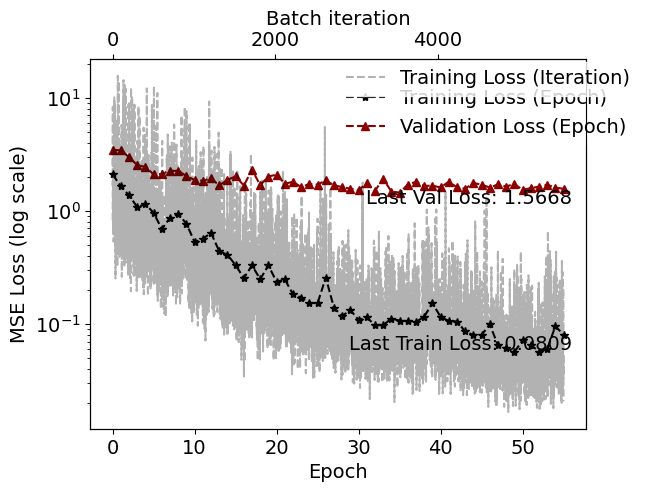

In [134]:
## High fidility model training from scratch WITHOUT any physical invariants:

# replace with your save directory
model_high_directory = r"D:\1_PhD_projects\3_code\Nasrin\originalGRUModel"


# Define your hyperparameters dictionary
hyperparameters = {
    'input_size': 19,
    'hidden_size': 512,
    'output_size': 10,
    'drop_out': 0.5,
    'num_epochs': 2000,
    'learning_rate': 0.001,
    'patience': 20,
    'seed': 42,
    'save_directory': model_high_directory,
}
# Define the model name using hyperparameters
model_name = f'\\from_scratch_FFT_plasInc_{hyperparameters["learning_rate"]}_{hyperparameters["patience"]}_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth' 

# Add the model_name and pretrained_model_path keys to the hyperparameters dictionary
hyperparameters['model_name'] = model_name

# Initialize ModelTrainer object
trainer = ModelTrainerDataDriven(train_loader=train_loader_f, val_loader=val_loader_f, test_loader=test_loader_f, hyperparameters=hyperparameters)

# Perform training
trainer.initialize_model()
trainer.define_loss_optimizer_scheduler()
trainer.train()

# Evaluate on test set
trainer.evaluate_test_set()

# Plot loss function
trainer.plot_loss_function()

In [135]:

# check point for model parameters:
model_directory = (r"D:\1_PhD_projects\3_code\Nasrin\originalGRUModel"
                   + '\\from_scratch_FFT_plasInc_0.005_20_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth')  
#scratch_low_fidelity_model_lr0.001_p10_L2reg_15features_26903samples_batch128_timesteps2001
print(model_directory)

# Load the pre-trained model
model = GRUModel(input_size=19, hidden_size=512, output_size=10, dropout=0.5)
model.load_state_dict(torch.load(model_directory))

for param in model.parameters():
    #param.requires_grad = False
    print(param.shape)
    #print(param)
    break

# Load the pre-trained model
model = GRUModel(input_size=19, hidden_size=64, output_size=11, dropout=0.5)
model.load_state_dict(torch.load(model_directory))
print(model)

# Move the pretrained model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Testing phase
plot_test_sample(model, test_loader_f, test_sample_id=17, stress_components = 9)
#plot_test_sample(model, test_loader_f,scalers=y_scaler_f, test_sample_id=78, stress_components = 1)

D:\1_PhD_projects\3_code\Nasrin\originalGRUModel\from_scratch_FFT_plasInc_0.005_20_robust_outlierDeleted786_scaled_data_batch8_timesteps101.pth


RuntimeError: Error(s) in loading state_dict for GRUModel:
	size mismatch for gru1.weight_ih_l0: copying a param with shape torch.Size([192, 19]) from checkpoint, the shape in current model is torch.Size([1536, 19]).
	size mismatch for gru1.weight_hh_l0: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for gru1.bias_ih_l0: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for gru1.bias_hh_l0: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for gru1.weight_ih_l1: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for gru1.weight_hh_l1: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for gru1.bias_ih_l1: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for gru1.bias_hh_l1: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for gru1.weight_ih_l2: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for gru1.weight_hh_l2: copying a param with shape torch.Size([192, 64]) from checkpoint, the shape in current model is torch.Size([1536, 512]).
	size mismatch for gru1.bias_ih_l2: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for gru1.bias_hh_l2: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for fc.weight: copying a param with shape torch.Size([11, 64]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([11]) from checkpoint, the shape in current model is torch.Size([10]).

Sample ID: 74


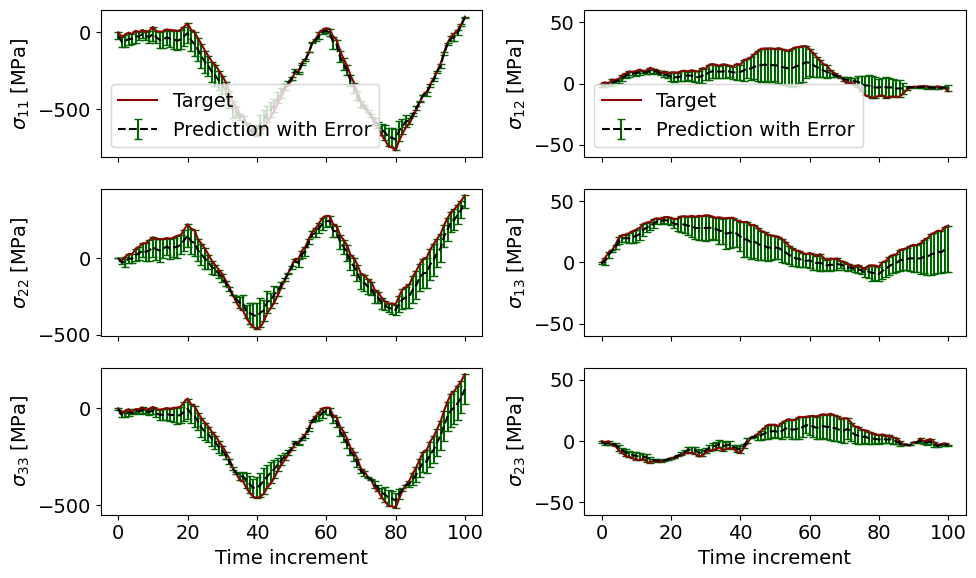

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

def plot_predictions_error(model, test_loader_f, y_scaler_f, test_sample_id=None):
    # Select the sample
    if test_sample_id is None:
        test_sample_id = random.randint(0, len(test_loader_f.dataset) - 1)
    
    print("Sample ID:", test_sample_id)
    x_target, y_target = test_loader_f.dataset[test_sample_id]

    model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Make predictions
    with torch.no_grad():
        y_pred = model(x_target.to(device)).to(x_target.device)

    # Scale back the predictions and target using y_scaler_f
    scaled_back_y_pred = np.zeros_like(y_pred)
    scaled_back_y_target = np.zeros_like(y_target)
    for i in range(y_pred.shape[1]):  # Assuming the first dimension is the time steps
        scaler = y_scaler_f[i]
        if scaler:
            scaled_back_y_pred[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
            scaled_back_y_target[:, i] = scaler.inverse_transform(y_target[:, i].reshape(-1, 1)).flatten()

    # Calculate absolute errors
    abs_errors = np.abs(scaled_back_y_pred - scaled_back_y_target)

    # Plot each component of stress in subfigures
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
    stress_labels = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{33}$', r'$\sigma_{12}$', r'$\sigma_{13}$', r'$\sigma_{23}$']

    for i in range(3):
        # Normal components with error bars
        axs[i][0].errorbar(range(len(scaled_back_y_pred[:, i])), scaled_back_y_pred[:, i], yerr=abs_errors[:, i], fmt='--', color='black', ecolor='darkgreen', capsize=3, label='Prediction with Error')
        axs[i][0].plot(scaled_back_y_target[:, i], '-', color='darkred', label='Target')
        axs[i][0].set_ylabel(f'{stress_labels[i]} [MPa]')
        #axs[i][0].set_ylim(-400,400)
        if i == 0: axs[i][0].legend()

    axs[-1][0].set_xlabel('Time increment')

    for i in range(3, 6):
        # Shear components with error bars
        axs[i-3][1].errorbar(range(len(scaled_back_y_pred[:, i])), scaled_back_y_pred[:, i], yerr=abs_errors[:, i], fmt='--', color='black', ecolor='darkgreen', capsize=3, label='Prediction with Error')
        axs[i-3][1].plot(scaled_back_y_target[:, i], '-', color='darkred', label='Target')
        axs[i-3][1].set_ylabel(f'{stress_labels[i]} [MPa]')
        axs[i - 3][1].set_ylim(-60,60)
        if i == 3: axs[i-3][1].legend()

    axs[-1][1].set_xlabel('Time increment')

    plt.tight_layout()
    #plt.savefig('images_FFpaper/sample_fine_tuned_model_prediction_on_cyclicS12_loads_errors.eps', format='eps')
    plt.show()

plot_predictions_error(model,test_loader_f, y_scaler_f, test_sample_id=74)

In [90]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, test_loader_f, y_scaler_f, test_sample_ids=None):
    # Default to random selection of 3 samples if none are provided
    if test_sample_ids is None:
        test_sample_ids = random.sample(range(len(test_loader_f.dataset)), 3)
    
    # Set model to evaluation mode
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
    stress_labels = [r'$\sigma_{11}$', r'$\sigma_{22}$', r'$\sigma_{33}$', r'$\sigma_{12}$', r'$\sigma_{13}$', r'$\sigma_{23}$']
    
    #colors = ['blue', 'green', 'purple']  # Unique colors for different samples
    colors = ['#000000','darkgreen','#800000']
    
    for idx, test_sample_id in enumerate(test_sample_ids):
        print(f'Processing sample {test_sample_id}')
        
        x_target, y_target = test_loader_f.dataset[test_sample_id]
        
        with torch.no_grad():
            y_pred = model(x_target.to(device))
        
        y_pred = y_pred.to(x_target.device)
        
        scaled_back_y_pred = np.zeros_like(y_pred)
        scaled_back_y_target = np.zeros_like(y_target)
        
        for i in range(y_pred.shape[1]):
            scaler = y_scaler_f[i]
            if scaler:
                scaled_back_y_pred[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
                scaled_back_y_target[:, i] = scaler.inverse_transform(y_target[:, i].reshape(-1, 1)).flatten()
            else:
                scaled_back_y_pred[:, i] = y_pred[:, i]
                scaled_back_y_target[:, i] = y_target[:, i]
        
        for i in range(3):
            axs[i][0].plot(scaled_back_y_pred[:, i], linestyle='--', color=colors[idx], label=f'GRU Prediction {test_sample_id}' if idx == 0 else None)
            axs[i][0].plot(scaled_back_y_target[:, i], linestyle='-', color=colors[idx], marker='', markersize=2, label=f'FFT {test_sample_id}' if idx == 0 else None)
            axs[i][0].set_ylabel(f'{stress_labels[i]} [MPa]')
            #axs[i][0].set_ylim(-100, 100)
        
        for i in range(3, 6):
            axs[i - 3][1].plot(scaled_back_y_pred[:, i], linestyle='--', color=colors[idx], label=f'GRU Prediction {test_sample_id}' if idx == 0 else None)
            axs[i - 3][1].plot(scaled_back_y_target[:, i], linestyle='-', color=colors[idx], marker='', markersize=2, label=f'FFT {test_sample_id}' if idx == 0 else None)
            axs[i - 3][1].set_ylabel(f'{stress_labels[i]} [MPa]')
            #axs[0][1].set_ylim(-100, 100)
            #axs[i - 3][1].set_ylim(-100, 100)
    
    axs[-1][0].set_xlabel('Time increment')
    axs[-1][1].set_xlabel('Time increment')
    
    plt.tight_layout()
    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    #plt.savefig(f'images_FFpaper/fineTunedFromRandomMFH_ToCyclicMFH_predictions/sample_prediction_MFHcyclic_{test_sample_ids}.eps', format='eps')
    plt.show()


Processing sample 58
Processing sample 74
Processing sample 9


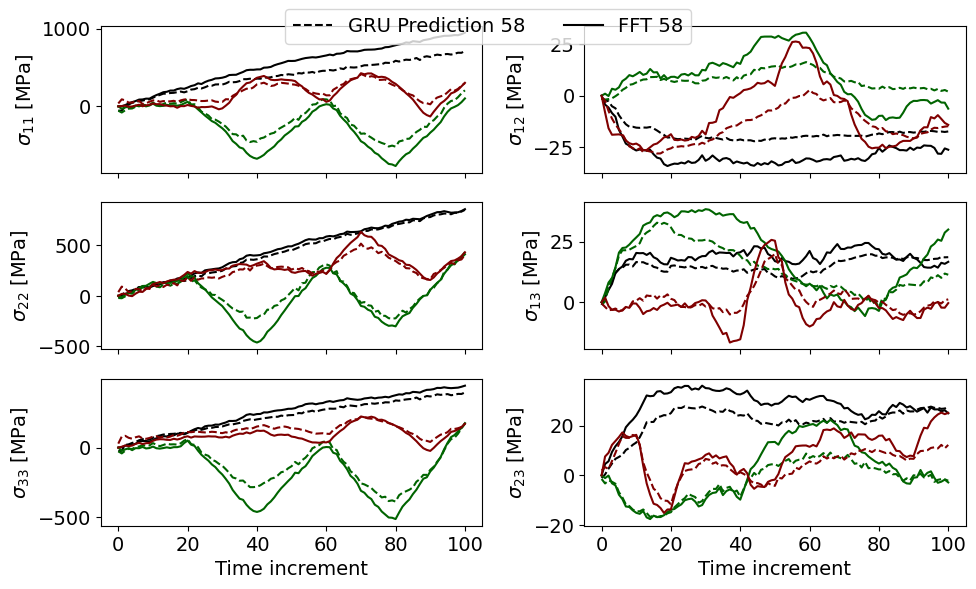

In [91]:
# Example usage:
plot_predictions(model, test_loader_f, y_scaler_f, test_sample_ids=[58, 74, 9])  # Sample IDs 7, 38, and 11 [58, 74, 9]